In [5]:
# Démarrage du thème 3
import visualID as vID
from visualID import color
vID.init()

**Début à:** Tuesday 31 May 2022, 17:56:46  
**Hostname:** insa-11357 (Linux)

<p style="text-align: center"><img width="800px" src="./svg/logoBegin.svg" style="margin-left:auto; margin-right:auto"></img></p>

# Traitement statistique de données
## 3. Apprentissage supervisé (*supervised Machine Learning*) appliqué à la classification<br>(régression logistique)

<div class="warn">
    <b style='color:red'>Ce thème n'est pas si complexe, mais l'analyse du code est réservée aux plus curieux et motivés.</b>
    <br>Il a pour objectif de montrer qu'il est possible de prédire une valeur sur la base d'une corrélation multifactorielle entre une <b>classe d'objets</b> (ici des espèces d'iris) et des <b>propriétés</b> (ou descripteurs, ici les largeurs et longueurs des pétales et des sépales) 
    <br><b style='color:red'>Les moins curieux doivent <i>a minima</i> lire les commentaires et exécuter ce code pour en comprendre le principe.</b>
   </div>

### 3.1. Introduction

#### 3.1.a. Objectif et principe général
On a vu dans la partie précédente (statistiques et régression) qu'il est possible de prédire une valeur ($\hat{y}$) sur la base d'une régression, c'est-à-dire du *fit* d'une équation mathématique qui relie deux variables entre elles ($y$ et $x$). On a pour cela utilisé les outils de régression offerts par la librairie `SciPy`. On a pu ainsi prédire la longueur d'un pétale d'iris, connaissant sa largeur, compte tenu de la relation linéaire entre longueur et largeur.

On a également constaté dans la première partie que la distribution jointe des caractéristiques longueurs et largeurs des pétales (`jointplot`) est presque suffisante pour classifier les 3 espèce d'iris (figure de gauche). La zone de recouvrement entre caractéristiques de pétales des espèces <i>versicolor</i> et <i>virginica</i> ne permet malheureusement pas de trancher entre grands iris <i>versicolor</i> et petits iris <i>virginica</i>. On voit sur la figure de droite que les sépales des iris <i>setosa</i> ont des dimensions différentes des deux autres, alors que <i>versicolor</i> et <i>virginica</i> ont pour la plupart des sépales de dimensions similaires.
<p style="text-align: center"><img width="900px" src="./svg/jointplot_petals-sepals_classification.png" style="margin-left:auto; margin-right:auto" id="img_jpc"></img></p>

<div class="warn">
Le premier objectif de ce TP est d'entraîner un modèle d'Intelligence Artificielle (IA) à <span style="color:red"><b>classifier</b></span> les espèces d'iris sur la base des <span style="color:red">longueurs (L<sub>P</sub>) et largeurs (&ell;<sub>P</sub>) de leurs pétales</span>. L'architecture est la suivante :

<img width="350px" src="./svg/IA-petales.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_IA_jpc"></img>   
    
C'est-à-dire qu'on va spécifier 2 paramètres en entrée, et qu'on veut obtenir en sortie les probabilités <i>P</i> que l'espèce d'iris caractérisée par ces deux propriétés soit de la famille <i>setosa</i>, <i>versicolor</i> ou <i>virginica</i>.
</div>

Il faut d'abord entraîner un modèle à faire un lien entre les 2 caractéristiques de pétales d'une part et espèce d'iris d'autre part. On parle d'**apprentissage supervisé** (*supervised machine learning*). Il existe plusieurs modèles statistiques qui peuvent faire ce type d'apprentissage visant à classifier des individus : arbres de décision, séparateurs à vaste marge (*support-vector machine*, SVM), réseaux de neurones artificiels (*artificial neural network*, ANN)... Même si ce n'est pas le plus efficace pour un problème aussi simple que celui-ci, on va utiliser une méthode d'apprentissage profond (*deep learning*), qui est un réseau de neurones particulier. On va découvrir que mettre au point un modèle de ce type n'est en réalité pas si compliqué que ça.

Voici à quoi ressemble dans ce cas précis une boîte noire exploitant le deep learning : 

<img width="250px" src="./svg/ANN-petales.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_ANN_jpc"></img>  

Elle est constituée de neurones artificiels tous connectés entre eux : (a) deux neurones d'entrée qui vont recevoir pour chaque espèce les largeurs et longueurs des pétales; (b) trois neurones de sortie qui vont contenir la probabilité pour que l'iris de cette taille soit *setosa* (*P*<sub>1</sub>), *versicolor* (*P*<sub>1</sub>) ou *virginica* (*P*<sub>3</sub>); (c) deux couches intermédiaires de neurones. Ces couches intermédiaires sont appelées couches cachées. On parle de *deep learning* pour tout ANN qui contient un mlinimum de deux couches cachées.

#### 3.1.b. Importation des librairies utiles

In [6]:
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils

### 3.2. Préparation des données

#### 3.2.a. Lecture de la base de données qui ont été adaptées au problème
Les données brutes sont en général mal adaptées aux algorithmes d'apprentissage automatique. La/le *data scientist* doit faire en amont un travail de transformation de ces données. On a ici appliqué au préalable un "encodage 1 parmi n" (ou *one-hot-encoding*) des espèces d'iris (les plus curieu(x)(ses) peuvent se référer à l'annexe). On va lire la nouvelle base de données (nommée iris_ohe.csv) afin de plus facilement comprendre en quoi consiste cet encodage.

In [7]:
dfi=pd.read_csv('./iris-data/iris_ohe.csv', sep="\t") #les colonnes sont séparées par des tabulations
print(f"Dfi. Structure (shape) :{dfi.shape}")
display(dfi)

Dfi. Structure (shape) :(150, 8)


,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica
0,5.1,3.5,1.4,0.2,setosa,1.0,0.0,0.0
1,4.9,3.0,1.4,0.2,setosa,1.0,0.0,0.0
2,4.7,3.2,1.3,0.2,setosa,1.0,0.0,0.0
3,4.6,3.1,1.5,0.2,setosa,1.0,0.0,0.0
4,5.0,3.6,1.4,0.2,setosa,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,0.0,0.0,1.0
146,6.3,2.5,5.0,1.9,virginica,0.0,0.0,1.0
147,6.5,3.0,5.2,2.0,virginica,0.0,0.0,1.0
148,6.2,3.4,5.4,2.3,virginica,0.0,0.0,1.0


Le nouveau ficher de données contient 3 nouvelles colonnes (*setosa*, *versicolor*, *virginica*), qui ne contient que des 0 ou des 1, qui ne sont rien d'autre que les probabilités que chacune des fleurs d'iris soit setosa, versicolor ou virginica. Comme c'est un botaniste qui a établi de façon sûre la classification de cette base de données, les probabilités ne peuvent valoir que 0 ou 1 (et bien entendu il ne peut y avoir qu'une seule valeur '1.0' par ligne). 

#### 3.2.b. Séparation des données en deux sous-ensembles d'apprentissage et de test
On est au c&oelig;ur de l'apprentissage automatique :
    <li> les algorithmes doivent être entraînés
    <li> pour entraîner un algorithme, on va lui donner une multitude d'exemples et, en fonction de la différence entre le résultat obtenu et le résultat attendu, le système va mettre à jour ses "coefficients" : c'est la phase d'apprentissage. Cette optimisation des coefficients se fait en minimisant l'écart entre propriété prédite et propriété réelle (la propriété dans ce cas étant l'espèce d'iris)
    <li> dans le cas d'un réseau de neurones, les coefficients sont les poids des connexions neuronales, ainsi qu'un paramètre caractéristique de chaque neurone
    <li> comme pour tout apprentissage, il faut vérifier que les acquis sont solides, c'est la phase de test. Une fois l'algorithme entraîné, on va lui soumettre de nouveaux exemples connus et évaluer sa capacité à donner la bonne réponse.
    
Tout jeu de données est séparé en deux sous-ensembles :
    <li> un jeu de données d'<b>apprentissage</b>
    <li> un jeu de données de <b>test</b>, indépendantes du jeu de données d'apprentissage, mais qui suit la même distribution de probabilité

(C'est ici une approche simplifiée. Dans une approche plus rigoureuse, on sépare la base de données en trois jeux : apprentissage, validation, test).
        
<div class="rq">        
Le principe est résumé dans la figure ci-dessous :
        
<img width="550px" src="./svg/holdout.png" style="margin-left:auto; margin-right:auto; display: block;" id="img_IA_holdout"></img>  
</div>

In [9]:
# création d'un jeu de données sous forme de dataFrame (data_train) qui contient 80% des échantillons, sélectionnés de façon aléatoire
# ce sont les données qui vont servir à l'entraînement de l'algorithme
data_train = dfi.sample(frac=0.8, axis='index') 
# création d'un nouveau dataFrame (data_test) qui contient les 20% restants
# ce sont les données qui vont servir à tester l'algorithme sur des données qui lui sont inconnues
data_test  = dfi.drop(data_train.index)

# sélection des données d'apprentissage (d'entraînement)
# x_train contient l'input, c'est-à-dire la largeur et la longueur de chacun des pétales du jeu de données data_train 
x_train = data_train[['petal_length','petal_width']]
# y_train contient ce qu'on veut faire apprendre à l'algorithme, c'est-à-dire le type de chacun  des iris du jeu de données data_train. 
# comme on veut que l'algorithme prédise des probabilités, on va lui faire apprendre ce type d'information
y_train = data_train[['setosa','versicolor','virginica']]
y_train_species = data_train[['species']] #sera utile à la fin pour comparer la prédiction et l'espèce réelle

# sélection des données de test
# on fait pareil que précédemment, mais pour tester l'algorithme (l'IA) une fois qu'il sera optimisé
x_test  = data_test[['petal_length','petal_width']]
y_test  = data_test[['setosa','versicolor','virginica']]
y_test_species = data_test[['species']]

print('x_train : ',x_train.shape)
display(x_train)
print('y_train : ',y_train.shape,'y_train_species : ',y_train_species.shape)
display(y_train, y_train_species)

x_train :  (120, 2)


,petal_length,petal_width
80,3.8,1.1
91,4.6,1.4
107,6.3,1.8
29,1.6,0.2
84,4.5,1.5
...,...,...
72,4.9,1.5
123,4.9,1.8
77,5.0,1.7
59,3.9,1.4


y_train :  (120, 3) y_train_species :  (120, 1)


,setosa,versicolor,virginica
80,0.0,1.0,0.0
91,0.0,1.0,0.0
107,0.0,0.0,1.0
29,1.0,0.0,0.0
84,0.0,1.0,0.0
...,...,...,...
72,0.0,1.0,0.0
123,0.0,0.0,1.0
77,0.0,1.0,0.0
59,0.0,1.0,0.0


,species
80,versicolor
91,versicolor
107,virginica
29,setosa
84,versicolor
...,...
72,versicolor
123,virginica
77,versicolor
59,versicolor


#### 3.2.c. Adaptation des données à la régression logistique par le réseau de neurones

In [33]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(x_train.values)
x_trainS = scaler.transform(x_train.values) #returns a numpy array
x_testS = scaler.transform(x_test.values) #returns a numpy array
x_trainD = pd.DataFrame(x_trainS, columns=x_train.columns, index=x_train.index)
x_testD = pd.DataFrame(x_testS, columns=x_test.columns, index=x_test.index)
display(x_trainD.describe().style.format("{0:.2f}").set_caption("Training set après normalisation (avec scikit-learn):"))
display(x_testD.describe().style.format("{0:.2f}").set_caption("Test set after après normalisation (avec scikit-learn):"))
x_train = x_trainS
x_test = x_testS
del x_trainD, x_testD, x_trainS, x_testS

,petal_length,petal_width
count,120.00,120.00
mean,0.00,-0.00
std,1.00,1.00
min,-1.64,-1.51
25%,-1.29,-1.11
50%,0.31,0.08
75%,0.71,0.77
max,1.74,1.66


,petal_length,petal_width
count,30.00,30.00
mean,-0.27,-0.28
std,1.02,1.01
min,-1.52,-1.51
25%,-1.35,-1.34
50%,0.08,0.01
75%,0.61,0.44
max,1.23,1.40


### 3.3. Modèle de réseau de neurones (ANN = artificial neural network)

#### 3.3.a. Définition du modèle

In [41]:
def get_model(NE): #NE = nombre de neurones d'entrée
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(NE, name='iLayer'))
    model.add(keras.layers.Dense(7, activation='relu', name='hLayer1'))
    model.add(keras.layers.Dense(5, activation='relu', name='hLayer2'))
    model.add(keras.layers.Dense(3, activation='softmax', name='oLayer'))
    
    model.compile(optimizer = 'adam',
                  loss      = 'categorical_crossentropy',
                  metrics   = ['accuracy'] )
    return model

#### 3.3.b. Apprentissage supervisé du réseau de neurones

In [42]:
vID.chrono_start()
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
print(f"x_train. Structure (shape) : {x_train.shape}")
print(f"x_test. Structure (shape) : {x_test.shape}")
print(f"y_train. Structure (shape) : {y_train.shape}")
print(f"y_test. Structure (shape) : {y_test.shape}")
ANNmodel=get_model( (2,)) # 2 neurones d'entrée
ANNmodel.summary()
vID.chrono_start()
ANNhistory = ANNmodel.fit(x_train,
                    y_train,
                    epochs          = 700,
                    batch_size      = 5,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks=[es])
vID.chrono_show()

x_train. Structure (shape) : (120, 2)
x_test. Structure (shape) : (30, 2)
y_train. Structure (shape) : (120, 3)
y_test. Structure (shape) : (30, 3)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hLayer1 (Dense)              (None, 7)                 21        
_________________________________________________________________
hLayer2 (Dense)              (None, 5)                 40        
_________________________________________________________________
oLayer (Dense)               (None, 3)                 18        
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________
Epoch 1/700
24/24 [==============================] - 1s 25ms/step - loss: 1.1305 - accuracy: 0.0765 - val_loss: 1.0706 - val_accuracy: 0.1000
Epoch 2/700
24/24 [==============================] - 0s 7ms/step - loss: 1.0954 - accuracy: 0.2573

### 3.4. Évaluation de la précision du réseau de neurones après apprentissage

#### 3.4.a. Évaluation numérique globale

In [43]:
evalANN_on_Train = ANNmodel.evaluate(x_train, y_train, verbose=0)
print(f"{color.GREEN}x_train / loss      : {evalANN_on_Train[0]:5.4f}{color.OFF}")
print(f"{color.GREEN}x_train/ accurracy  : {evalANN_on_Train[1]:5.4f}{color.OFF}")
print()
evalANN_on_Test = ANNmodel.evaluate(x_test, y_test, verbose=0)
print(f"{color.BLUE}x_train / loss      : {evalANN_on_Test[0]:5.4f}{color.OFF}")
print(f"{color.BLUE}x_train/ accurracy  : {evalANN_on_Test[1]:5.4f}{color.OFF}")

x_train / loss      : 0.0682
x_train/ accurracy  : 0.9750

x_train / loss      : 0.1253
x_train/ accurracy  : 0.9333


#### 3.4.b. Comportement du modèle vis-à-vis de chaque espèce d'iris

In [44]:
usp = dfi['species'].unique()
print(f"{color.BOLD}{color.GREEN}Catégories uniques d'iris :{color.OFF} {usp}")
# cette correspondance élément 0 <-> setosa ; élément 1 <-> versicolor ; élément 2 <-> virginica
# va servir à transformer les probabilités les plus élevées en espèce d'iris

y_train_hat=ANNmodel.predict(x_train)
ytr_hD = pd.DataFrame(y_train_hat, columns=usp, index=y_train.index)
# argmax renvoie l'indice de la valeur maximale selon un axe (0 = ligne / 1 = colonne)
# ça va ici nous renvoyer pour chaque ligne le numéro de la colonne qui contient la plus grande valeur de probabilité
# on convertit maintenant 0, 1 & 2 en espèce d'iris
iris_tr_hat = usp[np.argmax(y_train_hat,axis=1)]
# on ajoute cette colonne au dataframe ytr_hD
ytr_hD['Espèce prédite'] = pd.DataFrame(iris_tr_hat, index=y_train.index)
ytr_hD['Espèce observée'] = pd.DataFrame(y_train_species, index=y_train.index)
print(f"{color.BOLD}{color.BLUE}Test Set{color.OFF}. Comparaison entre espèce prédite et espèce observée")
pd.set_option('display.max_rows', None) #on veut afficher toutes les lignes des DataFrames
pd.options.display.float_format = '{:,.2f}'.format #on formatte les probabilités, sinon c'est illisible
display(ytr_hD)
pd.set_option('display.max_rows', 10) #reset de l'affichage: 5 premières et 5 dernières lignes
pd.options.display.float_format = None #reset de l'affichage: format standard 
diff_Pred_Obs=np.where(ytr_hD['Espèce prédite'] == ytr_hD['Espèce observée'], 0, 1)
print(f"Nombre d'erreurs : {np.sum(diff_Pred_Obs)}")

print()
y_test_hat=ANNmodel.predict(x_test)
ytt_hD = pd.DataFrame(y_test_hat, columns=usp, index=y_test.index)
# argmax renvoie l'indice de la valeur maximale selon un axe (0 = ligne / 1 = colonne)
# ça va ici nous renvoyer pour chaque ligne le numéro de la colonne qui contient la plus grande valeur de probabilité
# on convertit maintenant 0, 1 & 2 en espèce d'iris
iris_tt_hat = usp[np.argmax(y_test_hat,axis=1)]
# on ajoute cette colonne au dataframe ytt_hD
ytt_hD['Espèce prédite'] = pd.DataFrame(iris_tt_hat, index=y_test.index)
ytt_hD['Espèce observée'] = pd.DataFrame(y_test_species, index=y_test.index)
print(f"{color.BOLD}{color.RED}Test Set{color.OFF}. Comparaison entre espèce prédite et espèce observée.")
pd.set_option('display.max_rows', None) #on veut afficher toutes les lignes des DataFrames
pd.options.display.float_format = '{:,.2f}'.format #on formatte les probabilités, sinon c'est illisible
display(ytt_hD)
pd.set_option('display.max_rows', 10) #reset de l'affichage: 5 premières et 5 dernières lignes
pd.options.display.float_format = None #reset de l'affichage: 
diff_Pred_Obs=np.where(ytt_hD['Espèce prédite'] == ytt_hD['Espèce observée'], 0, 1)
print(f"Nombre d'erreurs : {np.sum(diff_Pred_Obs)}")

Catégories uniques d'iris : ['setosa' 'versicolor' 'virginica']
Test Set. Comparaison entre espèce prédite et espèce observée


,setosa,versicolor,virginica,Espèce prédite,Espèce observée
30,1.00,0.00,0.00,setosa,setosa
67,0.00,1.00,0.00,versicolor,versicolor
105,0.01,0.00,0.99,virginica,virginica
16,1.00,0.00,0.00,setosa,setosa
119,0.02,0.57,0.41,versicolor,virginica
89,0.00,1.00,0.00,versicolor,versicolor
84,0.01,0.94,0.05,versicolor,versicolor
128,0.01,0.00,0.99,virginica,virginica
64,0.00,1.00,0.00,versicolor,versicolor
114,0.01,0.00,0.99,virginica,virginica


Nombre d'erreurs : 3

Test Set. Comparaison entre espèce prédite et espèce observée.


,setosa,versicolor,virginica,Espèce prédite,Espèce observée
1,1.00,0.00,0.00,setosa,setosa
3,1.00,0.00,0.00,setosa,setosa
8,1.00,0.00,0.00,setosa,setosa
11,1.00,0.00,0.00,setosa,setosa
17,1.00,0.00,0.00,setosa,setosa
18,0.99,0.01,0.00,setosa,setosa
19,1.00,0.00,0.00,setosa,setosa
31,0.99,0.00,0.00,setosa,setosa
35,1.00,0.00,0.00,setosa,setosa
36,1.00,0.00,0.00,setosa,setosa


Nombre d'erreurs : 2


#### 3.4.c. Bilan de la performance du modèle prédictif sous forme de matrice de confusion

Training set. Matrice de confusion


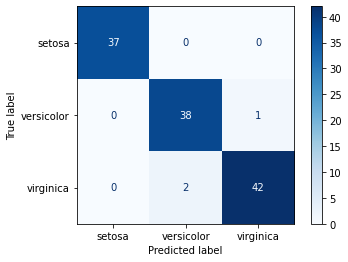

Test set. Matrice de confusion


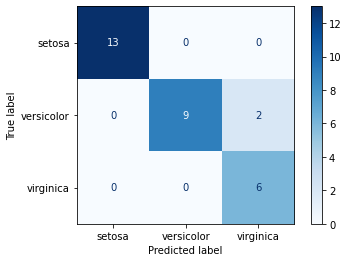

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
cm_labels = dfi['species'].unique()
print("Training set. Matrice de confusion")
cm_tr = confusion_matrix(np.argmax(y_train.to_numpy(),axis=1), np.argmax(y_train_hat,axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tr, display_labels=cm_labels)
disp.plot(cmap=plt.cm.Blues) #ici cm = diminutif de colormap dans matplotlib
plt.show()
print("Test set. Matrice de confusion")
cm_tt = confusion_matrix(np.argmax(y_test.to_numpy(),axis=1), np.argmax(y_test_hat,axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tt, display_labels=cm_labels)
disp.plot(cmap=plt.cm.Blues) #ici cm = diminutif de colormap dans matplotlib
plt.show()

### Bilan de la troisième partie

In [59]:
vID.end()

**Fin à:** Monday 30 May 2022, 14:16:36  
**Durée:** 00:20:41 473ms

<p style="text-align: center"><img width="800px" src="./svg/logoEnd.svg" style="margin-left:auto; margin-right:auto"></img></p>